# Example

This simple example demonstrates the whole process from initial atomic structure to training, evaluation and prediction. It includes:


1. **Create descriptors**: read input atomic structures (saved as extxyz files) and create descriptors and their derivatives.

2. **Create TFdataset**: create dataset in tensorflow format for training.

3. **Training**: train the potential and apply it for evaluation, prediction and inference.

4. **Save/load model**: save the trained model and then load it for retraining or prediction.


The code has been tested on Tensorflow 2.5 and 2.6.

In [1]:
import atomdnn

# 'float64' is used for reading data and train by default
atomdnn.data_type = 'float64'

# force and stress are evaluated by default, 
# if one only need to compute potential energy, then set compute_force to false
atomdnn.compute_force = True

# default value is for converting ev/A^3 to GPa
# note that: the predicted positive stress means tension and negative stress means compression
stress_unit_convert = 160.2176 

import numpy as np
import pickle
import tensorflow as tf
from atomdnn import data
from atomdnn.data import Data
from atomdnn.data import *
from atomdnn.descriptor import *
from atomdnn import network
from atomdnn.network import Network, print_output, save_output

## Create descriptors using function [create_descriptors](https://gao-group.github.io/atomdnn/module/descriptor.html#atomdnn.descriptor.create_descriptors)

In [2]:
descriptor = {'name': 'acsf', 
              'cutoff': 6.5,
              'etaG2':[0.01,0.1,1,5,10], 
              'etaG4': [0.01], 
              'zeta': [0.08,1.0,10.0,100.0],
              'lambda': [1.0, -1.0]}

elements = ['C']

In [3]:
xyzfiles='extxyz/example_extxyz.*' # a serials of extended xyz files, named as example_extxyz.1, ..., example_extxyz.n

mydata = create_descriptors(elements,xyzfiles,descriptor=descriptor)

Start creating fingerprints and derivatives for 50 files named 'dump_fp.*' ...
  so far finished for 10 images ...
  so far finished for 20 images ...
  so far finished for 30 images ...
  so far finished for 40 images ...
  so far finished for 50 images ...
It took 4.71 seconds.
The fingerprints files 'dump_fp.*' and derivatives files 'dump_der.*' are saved in folder '2107916592881485312'.

Using the generated descriptors to create and return an AtomDNN Data object.

Reading fingerprints from 'dump_fp.*' for total 50 files ...
  so far read 50 images ...

Reading derivatives from 'dump_der.*' for total 50 files (may take a while for large data set) ...
  so far read 50 images ...

total images = 50
max number of atoms = 4
number of fingerprints = 14
number of atom types = 1
max number of derivative pairs = 200

Reading outputs from 'example_extxyz.*' ...
  so far read 50 images ...


## Create tensorflow dataset (TFdataset) and save it 

In [4]:
# convert data to tensors
mydata.convert_data_to_tensor()

# create tensorflow dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((mydata.input_dict,mydata.output_dict))

# save the dataset
dataset_path = './example_tfdataset'
tf.data.experimental.save(tf_dataset, dataset_path)

# save the element_spec to disk for future loading, this is only needed for tensorflow lower than 2.6
with open(dataset_path + '/element_spec', 'wb') as out_: 
    pickle.dump(tf_dataset.element_spec, out_)

Conversion may take a while for large datasets...
It took 0.0058 second.


## Load TFdataset and split it for training, validation and test

In [5]:
dataset_path = './example_tfdataset'

# only for Tensorflow version lower than 2.6, need to specify element_spec
with open(dataset_path + '/element_spec', 'rb') as in_:
    element_spec = pickle.load(in_)

dataset = tf.data.experimental.load(dataset_path,element_spec=element_spec)

train_dataset, val_dataset, test_dataset = split_dataset(dataset,0.7,0.2,0.1,shuffle=True)

Traning data: 35 images
Validation data: 10 images
Test data: 5 images


## Create network using [Network](https://gao-group.github.io/atomdnn/module/network.html#atomdnn.network.Network) function

In [6]:
act_fun = 'relu' # any activation function provided by Tensorflow can be used
arch = [10,10] # Two layers, each with 10 neurons
model = Network(elements, descriptor, arch, act_fun)

## Train the model using function [train](https://gao-group.github.io/atomdnn/module/network.html#atomdnn.network.Network.train)



In [7]:
opt = 'Adam' # optimizer
loss_fun = 'mae' # loss function
scaling = 'std' # scaling the traning data with standardization
lr = 0.01 # learning rate
loss_weights = {'pe' : 1, 'force' : 1, 'stress': 0.1} # the weights in loss function

model.train(train_dataset,val_dataset,
            optimizer=opt, 
            loss_fun = loss_fun, 
            batch_size=10, 
            lr=0.01, 
            epochs=500, 
            scaling=scaling, 
            loss_weights=loss_weights,
            output_freq=100)

Learning rate is set to 0.010.
Forces are used for training.
Stresses are used for training.
Scaling factors are computed using training dataset.
Training dataset are standardized.
Validation dataset are standardized.
Training dataset will be shuffled during training.

===> Epoch 100/500 - 0.241s/epoch
     training_loss    - pe_loss: 0.340 - force_loss: 6.300 - stress_loss: 36.351 - total_loss: 10.275
     validation_loss  - pe_loss: 0.521 - force_loss: 7.819 - stress_loss: 42.217 - total_loss: 12.562

===> Epoch 200/500 - 0.208s/epoch
     training_loss    - pe_loss: 0.139 - force_loss: 2.052 - stress_loss: 3.163 - total_loss: 2.507
     validation_loss  - pe_loss: 0.218 - force_loss: 2.381 - stress_loss: 2.445 - total_loss: 2.843

===> Epoch 300/500 - 0.207s/epoch
     training_loss    - pe_loss: 0.091 - force_loss: 1.160 - stress_loss: 2.085 - total_loss: 1.459
     validation_loss  - pe_loss: 0.128 - force_loss: 1.791 - stress_loss: 2.957 - total_loss: 2.215

===> Epoch 400/500 - 

## Plot loss

The loss data are saved in the dictionary model.train_loss that has keys 'pe_loss','force_loss','stress_loss' and 'total_loss', which can be used to make customized plots when needed.

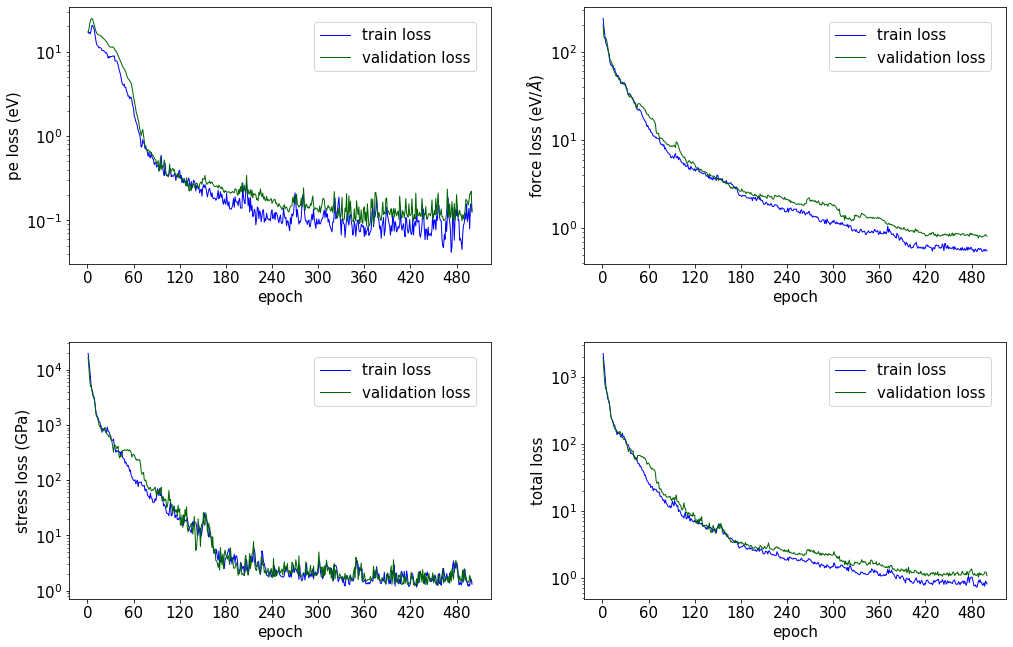

In [8]:
model.plot_loss()

## Model evaluation with [evaluate](https://gao-group.github.io/atomdnn/module/network.html#atomdnn.network.Network.evaluate) function

In [9]:
model.evaluate(test_dataset,return_prediction=False)

Evaluation loss is:
        pe_loss:       9.0080e-02
     force_loss:       6.2710e-01
    stress_loss:       1.1977e+00
     total_loss:       8.3695e-01
The total loss is computed using the loss weights - pe: 1.00 - force: 1.00 - stress: 0.10


## Model prediction with [predict](https://gao-group.github.io/atomdnn/module/network.html#atomdnn.network.Network.predict) function

The prediction using predict function can take inputs from TFdataset or the dataset created by create_descriptors.

In [10]:
# Prediction using the first 2 data in test TFdataset
inputs = get_input_dict(test_dataset.take(2)) 
outputs = model.predict(inputs)
print_output(outputs)

-----------------------------------------------------------------------------
image 1: potential energy = -28.860
stress_xx    stress_yy    stress_zz    stress_xy    stress_yz    stress_xz   
-4.8409e-01  9.2175e-01   5.4506e-02   2.6037e+00   2.6037e+00   1.8375e-02  
atom_id      fx           fy           fz          
1            -1.2259e+00  6.0526e+00   -1.0872e+00 
2            -3.3132e-01  -5.3743e+00  9.7941e-01  
3            3.2194e+00   3.9242e+00   -9.3347e-01 
4            -1.6622e+00  -4.6025e+00  1.0412e+00  
-----------------------------------------------------------------------------
image 2: potential energy = -28.534
stress_xx    stress_yy    stress_zz    stress_xy    stress_yz    stress_xz   
2.8587e+00   -3.8029e+00  4.4140e-02   -4.1479e-01  -4.1479e-01  -3.7333e-01 
atom_id      fx           fy           fz          
1            -7.2305e+00  -4.4921e+00  8.8790e-01  
2            6.3109e+00   5.6989e+00   1.6393e-01  
3            -4.0696e+00  2.0623e+00   3.709

In [11]:
# prediction using the original first three data in the original dataset 
inputs = mydata.get_input_dict(1,3)
outputs = model.predict(inputs)
print_output(outputs)
save_output(outputs,'prediction.txt') # the prediciton can be saved to file

-----------------------------------------------------------------------------
image 1: potential energy = -28.075
stress_xx    stress_yy    stress_zz    stress_xy    stress_yz    stress_xz   
-7.7153e-01  -6.4598e-01  1.0210e-01   -1.5918e+00  -1.5918e+00  -6.7456e-01 
atom_id      fx           fy           fz          
1            -6.1100e+00  -7.4225e+00  1.0656e+00  
2            4.1103e+00   8.3741e+00   -1.2936e+00 
3            6.3585e+00   4.6177e-01   -2.3042e-01 
4            -4.3588e+00  -1.4134e+00  4.5840e-01  
-----------------------------------------------------------------------------
image 2: potential energy = -28.505
stress_xx    stress_yy    stress_zz    stress_xy    stress_yz    stress_xz   
3.4159e+00   -2.4915e+00  9.9922e-02   1.2514e+00   1.2514e+00   -1.9193e-01 
atom_id      fx           fy           fz          
1            -5.4221e+00  7.7967e+00   1.6870e+00  
2            2.3565e+00   -9.2040e+00  -4.8374e-01 
3            -2.5532e+00  -5.1804e+00  -3.06

## Model Inference with [inference](https://gao-group.github.io/atomdnn/module/network.html#atomdnn.network.Network.inference) function 

An alternative way to do prediction using an arbitary atomic structure.

In [12]:
outputs = model.inference('lmpdata',format='lammps-data',style='atomic')
print_output(outputs)

-----------------------------------------------------------------------------
image 1: potential energy = -28.075
stress_xx    stress_yy    stress_zz    stress_xy    stress_yz    stress_xz   
-7.7153e-01  -6.4598e-01  1.0210e-01   -1.5918e+00  -1.5918e+00  -6.7456e-01 
atom_id      fx           fy           fz          
1            -6.1100e+00  -7.4225e+00  1.0656e+00  
2            4.1103e+00   8.3741e+00   -1.2936e+00 
3            6.3585e+00   4.6177e-01   -2.3042e-01 
4            -4.3588e+00  -1.4134e+00  4.5840e-01  


## Save model

Noted that saved model can be used for LAMMPS

In [13]:
network.save(model,'example.tfdnn')

INFO:tensorflow:Assets written to: example.tfdnn/assets


## Load model

Imported model can be used for continuous training, evaluation and prediction

In [14]:
imported_model = network.load('example.tfdnn')

Network has been inflated! self.built: True


In [15]:
inputs = get_input_dict(test_dataset.skip(2).take(1)) 
outputs = imported_model.predict(inputs,pe_peratom=True)
print_output(outputs)

-----------------------------------------------------------------------------
image 1: potential energy = -28.808
stress_xx    stress_yy    stress_zz    stress_xy    stress_yz    stress_xz   
1.4873e+00   1.6794e+00   3.7979e-02   2.0698e+00   2.0698e+00   -2.5191e-02 
atom_id      fx           fy           fz           pe/atom     
1            -2.8741e+00  -7.6339e-01  -1.1687e+00  -7.1234e+00 
2            -4.1952e+00  -1.1841e+00  1.3017e+00   -7.4537e+00 
3            3.4244e+00   7.1822e+00   -7.5894e-01  -7.2648e+00 
4            3.6449e+00   -5.2347e+00  6.2595e-01   -6.9661e+00 
